In [20]:
%load_ext autoreload
%autoreload 2
from utilities.variational import *
from utilities.misc import *
from utilities.chemical import *
from utilities.idinserter import IdInserter
from openfermion.chem import MolecularData
from openfermionpyscf import run_pyscf
import matplotlib.pyplot as plt
from tqdm import tqdm
from utilities.simplifier import Simplifier
from utilities.unitary_killer import UnitaryMurder
from utilities.variational import VQE


bd= 1.5
problem_config ={"problem" : "H2", "geometry": [('H', (0., 0., 0.)), ('H', (0., 0., bd)), ('H', (0., 0., 2*bd)), ('H', (0., 0., 3*bd))], 
                  "multiplicity":1, "charge":0, "basis":"sto-3g"}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
vqe_handler = VQE(n_qubits=8,problem_config=problem_config, optimizer="sgd", lr=.01,verbose=0)

heas = {}
for L in tqdm(range(10)):
    hea_indices = vqe_handler.hea_ansatz_indexed_circuit(L,full=True)
    vv = vqe_handler.vqe(hea_indices)
    heas[L]=np.min(vv[-1].history["energy"])

100%|██████████| 10/10 [04:36<00:00, 27.67s/it]


In [53]:
from utilities.evaluator import Evaluator
bd=1.5
args={"n_qubits":8,"problem_config":{"problem" : "H4", "geometry": [("H", (0., 0., 0)), ("H", (0., 0., bd)), ("H", (0., 0., 2*bd)), ("H", (0., 0., 3*bd))], 
                                     "multiplicity":1, "charge":0, "basis":"sto-3g"},"specific_name":"H4/N8_geometry_H4_multip_[(H, (0.0, 0.0, 0.0)), (H, (0.0, 0.0, 1.5)), (H, (0.0, 0.0, 3.0)), (H, (0.0, 0.0, 4.5))]_charge_1_basis0_quiet"}

evaluator = Evaluator(args,loading=True, path="../data-vans/",nrun_load=7)
vanslowest_ent = evaluator.raw_history[len(list(evaluator.raw_history.keys()))-1][-1]

evaluator = Evaluator(args,loading=True, path="../data-vans/",nrun_load=1)
vanslowest_sep = evaluator.raw_history[len(list(evaluator.raw_history.keys()))-1][-1]

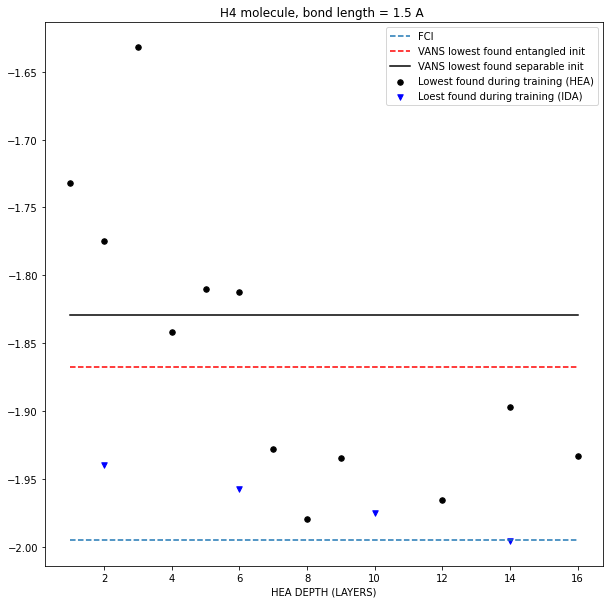

In [60]:
plt.figure(figsize=(10,10))
plt.title("H4 molecule, bond length = 1.5 A ")
plt.scatter(list(heas.keys())[1:], list(heas.values())[1:],color="black",s=30,label="Lowest found during training (HEA)")
plt.scatter(list(idens.keys()),list(idens.values()),s=30, marker='v', color="blue", label="Loest found during training (IDA)")
plt.plot(ls,np.ones(len(ls))*vqe_handler.lower_bound_energy,'--',label="FCI")
plt.plot(ls,np.ones(len(ls))*vanslowest_ent,'--',color="red",label="VANS lowest found entangled init")
plt.plot(ls,np.ones(len(ls))*vanslowest_sep,'-',color="black",label="VANS lowest found separable init")

plt.xlabel("HEA DEPTH (LAYERS)")
plt.legend()
plt.savefig("h4_first_attemps.png")

In [39]:
idens = {}
idins = IdInserter(n_qubits = len(vqe_handler.qubits))
for L in tqdm(range(2,16,4)):
    c=[vqe_handler.number_of_cnots+k for k in range(vqe_handler.n_qubits,2*vqe_handler.n_qubits)]
    for k in range(L):
        for i in range(len(vqe_handler.qubits)):
            c+=idins.resolution_2cnots(i,(i+1)%len(vqe_handler.qubits))
        c+=[vqe_handler.number_of_cnots+k for k in range(vqe_handler.n_qubits,2*vqe_handler.n_qubits)]

    vv = vqe_handler.vqe(c)
    idens[L] = np.min(vv[-1].history["energy"])

100%|██████████| 4/4 [03:45<00:00, 56.35s/it]


In [40]:
for L in tqdm([12,14,16]):
    hea_indices = vqe_handler.hea_ansatz_indexed_circuit(L,full=True)
    vv = vqe_handler.vqe(hea_indices)
    heas[L]=np.min(vv[-1].history["energy"])

100%|██████████| 3/3 [02:58<00:00, 59.52s/it]


Text(0.5, 0, 'HEA DEPTH (LAYERS)')

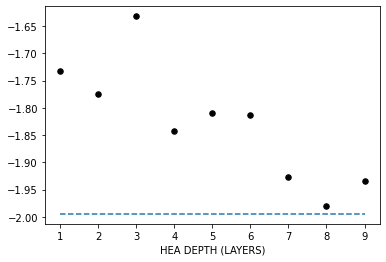

In [41]:
plt.scatter(ls, vals,color="black",s=30,label="Lowest found during training (HEA)")
plt.plot(ls,np.ones(len(ls))*vqe_handler.lower_bound_energy,'--',label="FCI")
plt.xlabel("HEA DEPTH (LAYERS)")

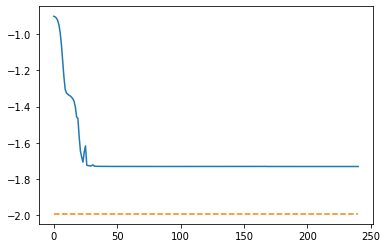

In [18]:
plt.plot(vv[-1].history["energy"])
plt.plot(range(len(vv[-1].history["energy"])),np.ones(len(vv[-1].history["energy"]))*vqe_handler.lower_bound_energy,'--')